In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn import metrics
import lightgbm as lgbm
from sklearn import metrics
import re
import pickle

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Все основные агрегаты считались в спарке

In [2]:
def memory_usage(df, name):
    mb = df.memory_usage().sum() / 1024 / 1024
    print(name + ' use {:.2f} mb in memory'.format(mb))

# TODO
* сделать радельные модели для пользователей, по которым есть информация и по которым нет (Если делать модель, основанную только на признаков ответов, то она получается очень скудной по скору)
* Дабрать больше данных для обучения модели (желательно более современных)

# Загрузка данных

In [3]:
kaggle_data_path = './data'
#kaggle_data_path = '/kaggle/input'
# user_data_path = './data/spark_data_src'
user_data_path = './data/spark_data'
for dirname, _, filenames in os.walk(kaggle_data_path):
    for filename in filenames:
        current_file_path = os.path.join(dirname, filename)
        if 'lectures.csv' in current_file_path:
            lectures_path = current_file_path
        if 'questions.csv' in current_file_path:
            questions_path = current_file_path
        if 'train.csv' in current_file_path:
            data_path = current_file_path
#         print(current_file_path)

In [18]:
with open(os.path.join(user_data_path, 'train_data_random.pickle'), 'rb') as fo:
    train_data = pickle.load(fo)
memory_usage(train_data, 'train_data')
with open(os.path.join(user_data_path, 'train_data_newbie.pickle'), 'rb') as fo:
    train_data_newbie = pickle.load(fo)
memory_usage(train_data_newbie, 'train_data')
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    question_characteristics = pickle.load(fo)
memory_usage(question_characteristics, 'question_characteristics')
with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'rb') as fo:
    users_chars = pickle.load(fo)
memory_usage(users_chars, 'users_characteristics')
tags = ['first_user_answers', 'last_user_answers', 'random']
users_chars_valid = {}
valid_data = {}
for tag in tags:
    with open(os.path.join(user_data_path, 'users_characteristics_' + tag + '.pickle'), 'rb') as fo:
        users_chars_valid[tag] = pickle.load(fo)
    memory_usage(users_chars_valid[tag], 'users_characteristics_' + tag)
    with open(os.path.join(user_data_path, 'valid_data_' + tag + '.pickle'), 'rb') as fo:
        valid_data[tag] = pickle.load(fo)
    memory_usage(valid_data[tag], 'valid_data')

train_data use 1373.29 mb in memory
train_data use 388.13 mb in memory
question_characteristics use 0.77 mb in memory
users_characteristics use 30.03 mb in memory
users_characteristics_first_user_answers use 30.03 mb in memory
valid_data use 6.12 mb in memory
users_characteristics_last_user_answers use 30.03 mb in memory
valid_data use 10.15 mb in memory
users_characteristics_random use 30.01 mb in memory
valid_data use 5.99 mb in memory


In [19]:
# Расчитываем средние характеристики
part_time_characteristics = (
    question_characteristics
    .groupby('part')['question_elapsed_time_mean']
    .mean().reset_index()
)
part_time_characteristics.columns = ['part', 'question_elapsed_time_part_mean']
df = users_chars[['user_elapsed_time', 'user_bundle_count']].sum()
user_time_mean = df['user_elapsed_time'] / df['user_bundle_count']

In [5]:
# with open(os.path.join(user_data_path, 'train_data_random.pickle'), 'wb') as fo:
#     train_data['attempts'] = train_data['attempts'].astype(int)
#     pickle.dump(train_data, fo)

In [17]:
# with open(os.path.join(user_data_path, 'train_data_newbie.pickle'), 'wb') as fo:
#     train_data_newbie['attempts'] = train_data_newbie['attempts'].astype(int)
#     pickle.dump(train_data_newbie, fo)

In [6]:
# with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'wb') as fo:
#     df = users_chars.copy()
#     df['user_delay_mean'] = df['user_total_bundle_delay'] / df['user_bundle_count']
#     df.drop(columns=['user_total_bundle_delay'], inplace=True)
#     df['user_explanation_rate'] = df['user_explanation_count'] / df['user_bundle_count']
#     df['user_elapsed_time_mean'] = df['user_elapsed_time'] / df['user_bundle_count']
#     pickle.dump(df, fo)

In [7]:
# tags = ['first_user_answers', 'last_user_answers', 'random']
# for tag in tags:
#     with open(os.path.join(user_data_path, 'users_characteristics_' + tag + '.pickle'), 'wb') as fo:
#         df = users_chars_valid[tag].copy()
#         df['user_delay_mean'] = df['user_total_bundle_delay'] / df['user_bundle_count']
#         df.drop(columns=['user_total_bundle_delay'], inplace=True)
#         df['user_explanation_rate'] = df['user_explanation_count'] / df['user_bundle_count']
#         df['user_elapsed_time_mean'] = df['user_elapsed_time'] / df['user_bundle_count']
#         pickle.dump(df, fo)

In [8]:
# tags = ['first_user_answers', 'last_user_answers', 'random']
# for tag in tags:
#     with open(os.path.join(user_data_path, 'valid_data_' + tag + '.pickle'), 'wb') as fo:
#         df = valid_data[tag][['row_id', 'timestamp', 'user_id', 'content_id',
#                         'task_container_id', 'answered_correctly',
#                         'prior_question_elapsed_time', 'prior_question_had_explanation']]
#         # Собираем общий массив
#         df['content_type_id'] = 0
#         df = df.loc[df.answered_correctly != -1, :]
#         pickle.dump(df, fo)

# Обновление характеристик

In [6]:
def split_characteristics(test_df, user_chars, q_chars):
    users = list(test_df.user_id.unique())
    index = user_chars.user_id.isin(users)
    static_user_chars = user_chars.loc[~index, :]
    update_user_chars = user_chars.loc[index, :]
    
    contents = list(test_df.content_id.unique())
    index = q_chars.content_id.isin(contents)
    static_q_chars = q_chars.loc[~index, :]
    update_q_chars = q_chars.loc[index, :]
    
    return static_user_chars, update_user_chars, static_q_chars, update_q_chars

In [7]:
def merge_data(data, q_chars):
    # Согласованность колонок теста и трейна оставляет желать лучшего
    data_columns = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
                    'prior_question_elapsed_time', 'prior_question_had_explanation']
    data = data.loc[data['content_type_id'] != 1, data_columns]
    data.drop(columns='content_type_id', inplace=True)
    
    # Собираем общий массив
    full_df = (
        data
        .merge(q_chars, on='content_id', how='left')
    )
    
    # Заполнение наллов в просмотре ответов
    index = full_df['prior_question_had_explanation'].isnull()
    full_df.loc[index, 'prior_question_had_explanation'] = False
    full_df.loc[index, 'prior_question_elapsed_time'] = 0.
    
    # Приводим типы
    full_df['part'] = full_df['part'].astype('int8')
    full_df['prior_question_had_explanation'] = full_df['prior_question_had_explanation'].astype('int8')
    full_df['prior_question_elapsed_time'] = full_df['prior_question_elapsed_time'].astype('float64')
    
    return full_df

In [8]:
def get_test_users_characteristics(full_df):
    # Характеристики пачек
    group_cols = ['user_id', 'timestamp', 'bundle_id', 
                  'prior_question_elapsed_time', 
                  'prior_question_had_explanation']
    bundles = full_df.loc[:, group_cols].drop_duplicates()
    bundles['bundle_id_str'] = ' ' + bundles['bundle_id'].astype(str) + ','
    # Характеристики пользователей
    aggregates = {
        'prior_question_elapsed_time': ['sum'],
        'prior_question_had_explanation': ['sum'],
        'bundle_id_str': ['sum'],
        'bundle_id': ['count'],
    }
    group_cols = ['user_id']
    users = bundles.groupby(group_cols).agg(aggregates).reset_index()
    users.columns = group_cols + ['user_elapsed_time_current', 
                                  'user_explanation_count_current',
                                  'user_bundles_list_current',
                                  'user_bundle_count_current']
    
    return users

In [9]:
def update_answers_characteristics(test_df, correct_answers, static_user_chars, 
                                   update_user_chars, static_q_chars, update_q_chars):
    # Характеристики пачек
    test_df = test_df.loc[:, ['user_id', 'content_id']]
    test_df['answered_correctly'] = correct_answers
    aggregates = {
        'answered_correctly': ['sum', 'count'],
    }
    # Характеристики пользователей
    users_chars = test_df.groupby('user_id').agg(aggregates).reset_index()
    users_chars.columns = ['user_id', 'user_correct_answers_count_new', 'user_answers_count_new']
    update_user_chars = update_user_chars.merge(users_chars, on='user_id', how='left').fillna(0)
    update_user_chars.loc[:, 'user_answers_count'] += update_user_chars.loc[:, 'user_answers_count_new']
    update_user_chars.loc[:, 'user_correct_answers_count'] += update_user_chars.loc[:, 'user_correct_answers_count_new']
    update_user_chars.loc[:, 'user_accuracy'] = update_user_chars.loc[:, 'user_correct_answers_count'] / update_user_chars.loc[:, 'user_answers_count']
    user_chars = pd.concat([static_user_chars, update_user_chars[static_user_chars.columns]])
    
    # Характеристики вопросов
    q_chars = test_df.groupby('content_id').agg(aggregates).reset_index()
    q_chars.columns = ['content_id', 'question_correct_answers_count_new', 'question_answers_count_new']
    update_q_chars = update_q_chars.merge(q_chars, on='content_id', how='left').fillna(0)
    update_q_chars.loc[:, 'question_answers_count'] += update_q_chars.loc[:, 'question_answers_count_new']
    update_q_chars.loc[:, 'question_correct_answers_count'] += update_q_chars.loc[:, 'question_correct_answers_count_new']
    update_q_chars.loc[:, 'question_correct_answers_mean'] = update_q_chars.loc[:, 'question_correct_answers_count'] / update_q_chars.loc[:, 'question_answers_count']
    q_chars = pd.concat([static_q_chars, update_q_chars[static_q_chars.columns]])
    
    return user_chars, q_chars

In [10]:
# %%time
# merged_df = merge_data(valid_data, question_characteristics)
# current_chars = get_test_users_characteristics(merged_df)

In [11]:
def update_users_characteristics(current_chars, users_chars):
    # Добавляем старые характеристики к новым
    update_user_chars = (
        current_chars
        .merge(users_chars, on='user_id', how='left')
    )
    # Убираем наллы
    index_nulls = update_user_chars['user_bundle_count'].isnull()
    numeric_columns = ['user_bundle_count', 'user_explanation_count', 
                       'user_elapsed_time', 'user_delay_mean']
    update_user_chars.loc[index_nulls, numeric_columns] = 0
    update_user_chars['user_bundle_count'] = update_user_chars['user_bundle_count'].astype(int)
    update_user_chars['user_explanation_count'] = update_user_chars['user_explanation_count'].astype(int)
    update_user_chars.loc[index_nulls, 'user_accuracy'] = 0.5
    update_user_chars.loc[index_nulls, 'user_bundles_list'] = ''
    
    # Обновляем характеристики
    update_columns = ['user_bundle_count', 'user_explanation_count', 
                      'user_elapsed_time', 'user_bundles_list']
    for col in update_columns:
        update_user_chars.loc[:, col] += update_user_chars.loc[:, col + '_current']
    
    update_user_chars = update_user_chars.loc[:, users_chars.columns]
    # Рассчитываем пользовательские признаки
    update_user_chars.loc[:, 'user_explanation_rate'] = update_user_chars.loc[:, 'user_explanation_count'] / update_user_chars.loc[:, 'user_bundle_count']
    update_user_chars.loc[:, 'user_elapsed_time_mean'] = update_user_chars.loc[:, 'user_elapsed_time'] / update_user_chars.loc[:, 'user_bundle_count']
    
    return update_user_chars

In [12]:
# new_user_chars, current_user_chars = update_users_characteristics(current_chars, users_chars)

In [13]:
def norm_column(series):
#     mean_val = series.mean()
#     delta_val = series.std() + 0.00001
#     return (series - mean_val) / delta_val
    return series
def form_features(merged_df, users_chars, part_chars, user_time_mean):
    output = (
        merged_df.drop(columns=['content_id'])
        .merge(users_chars, on='user_id', how='left')
        .merge(part_chars, on='part', how='left')
        .set_index('row_id')
    )
    
    output['attempts'] = output.apply(lambda x: len(re.findall(' ' + str(x.bundle_id) + ',', x.user_bundles_list)), axis=1).astype('int8')
    output.loc[output['attempts'] > 5, 'attempts'] = 5
    output.loc[:, 'attempts'] -= 1
    output.drop(columns=['bundle_id', 'user_bundles_list', 'timestamp', 'user_id'], inplace=True)
    
    output.loc[:, 'user_accuracy_hmean'] = output.loc[:, 'user_accuracy'] * output.loc[:, 'question_correct_answers_mean'] / (output.loc[:, 'user_accuracy'] + output.loc[:, 'question_correct_answers_mean'])
    
    output.loc[:, 'user_delay_over_part'] = (output.loc[:, 'prior_question_elapsed_time'] - output.loc[:, 'question_elapsed_time_part_mean']) / output.loc[:, 'question_elapsed_time_part_mean']
    output.loc[:, 'user_delay_over_users'] = (output.loc[:, 'prior_question_elapsed_time'] - user_time_mean) / user_time_mean
    
    # Нормировка
    columns_for_norm = ['question_elapsed_time_mean', 'question_answers_count', 
                        'user_bundle_count', 'user_elapsed_time_mean']
    for col in columns_for_norm:
        output.loc[:, col] = norm_column(output.loc[:, col])
        
    return output
def form_train_features(train_data, part_chars, user_time_mean):
    output = (
        train_data.drop(columns=['content_id', 'user_id', 'timestamp', 'bundle_id'])
    )
    
    index_nulls = output.user_explanation_count.isnull()
    output.loc[index_nulls, ['user_explanation_count', 'user_total_bundle_delay']] = 0
    output['user_explanation_count'] = output['user_explanation_count'].astype(int)
    
    output['user_accuracy'] = output['user_correct_answers_count'] / output['user_answers_count']
    output['user_elapsed_time_mean'] = output['user_elapsed_time'] / output['user_bundle_count']
    output['user_delay_mean'] = output['user_total_bundle_delay'] / output['user_bundle_count']
    output['user_explanation_rate'] = output['user_explanation_count'] / output['user_bundle_count']
    index_nulls = output.user_delay_mean.isnull()
    output.loc[index_nulls, ['user_delay_mean', 'user_explanation_rate', 'user_elapsed_time_mean']] = 0.
    output.loc[output['attempts'] > 5, 'attempts'] = 5
    output.loc[:, 'attempts'] -= 1
    
    output.loc[:, 'user_accuracy_hmean'] = output.loc[:, 'user_accuracy'] * output.loc[:, 'question_correct_answers_mean'] / (output.loc[:, 'user_accuracy'] + output.loc[:, 'question_correct_answers_mean'])
    
    output = output.merge(part_chars, on='part', how='left')
    output.loc[:, 'user_delay_over_part'] = (output.loc[:, 'prior_question_elapsed_time'] - output.loc[:, 'question_elapsed_time_part_mean']) / output.loc[:, 'question_elapsed_time_part_mean']
    output.loc[:, 'user_delay_over_users'] = (output.loc[:, 'prior_question_elapsed_time'] - user_time_mean) / user_time_mean
    
    # Нормировка
    columns_for_norm = ['question_elapsed_time_mean', 'question_answers_count', 
                        'user_bundle_count', 'user_elapsed_time_mean']
    for col in columns_for_norm:
        output.loc[:, col] = norm_column(output.loc[:, col])
    
    out_columns = ['part', 'question_elapsed_time_mean', 'question_had_explanation_mean',
       'question_answers_count', 'question_correct_answers_mean',
       'question_user_var', 'user_bundle_count', 'user_accuracy_hmean',
       'user_delay_mean', 'user_explanation_rate', 'user_elapsed_time_mean',
       'attempts', 'answered_correctly', 'user_delay_over_part', 'user_delay_over_users']
        
    return output.loc[:, out_columns]

In [14]:
def make_features_df(test_df, q_chars, users_chars, part_chars, user_time_mean):
    merged_df = merge_data(test_df, q_chars)
    current_chars = get_test_users_characteristics(merged_df)
    user_chars = update_users_characteristics(current_chars, users_chars)
    features = form_features(merged_df, user_chars, part_chars, user_time_mean)
    
    out_columns = ['part', 'question_elapsed_time_mean', 'question_had_explanation_mean',
                   'question_answers_count', 'question_correct_answers_mean',
                   'question_user_var', 'user_bundle_count', 'user_accuracy_hmean',
                   'user_delay_mean', 'user_explanation_rate', 'user_elapsed_time_mean',
                   'attempts', 'user_delay_over_part', 'user_delay_over_users']

    memory_usage(features, 'features_df')
    memory_usage(user_chars, 'user_chars')
    
    return features[out_columns], user_chars

In [27]:
def make_features_newbie(features):
    columns = ['part', 'question_elapsed_time_mean', 'question_had_explanation_mean', 'question_answers_count', 
               'question_correct_answers_mean', 'question_user_var', 'user_delay_over_part', 
               'user_delay_over_users', 
               'answered_correctly']
    return features[columns]
def make_features_profi(features, user_time_mean):
    features.loc[:, 'user_delay_mean_over_users'] = (features.loc[:, 'user_elapsed_time_mean'] - user_time_mean) / user_time_mean
    columns = ['part', 'user_accuracy_hmean', 'question_correct_answers_mean', 'attempts', 'user_bundle_count', 
               'user_explanation_rate', 'question_had_explanation_mean', 'user_delay_mean_over_users', 
               'answered_correctly'
              ]
    
    return features[columns]

In [71]:
def make_prediction(valid_df, model_profi, model_newbie, newbie_threshold):
    index_profi = valid_df.user_bundle_count > newbie_threshold
    valid_df.loc[:, 'prediction'] = 0.5
    
    valid_df_profi = make_features_profi(valid_df.loc[index_profi, :], user_time_mean)
    valid_df.loc[index_profi, 'prediction'] = model_profi.predict(valid_df_profi)
    
    valid_df_newbie = make_features_newbie(valid_df.loc[~index_profi, :])
    valid_df.loc[~index_profi, 'prediction'] = model_newbie.predict(valid_df_newbie)
    
    return valid_df['prediction']

In [77]:
train_df

,part,question_elapsed_time_mean,question_had_explanation_mean,question_answers_count,question_correct_answers_mean,question_user_var,user_bundle_count,user_accuracy_hmean,user_delay_mean,user_explanation_rate,user_elapsed_time_mean,attempts,answered_correctly,user_delay_over_part,user_delay_over_users,user_delay_mean_over_users
0,5,27659.691630,0.995595,924,0.554113,0.951299,88,0.289617,-0.033189,0.920455,21170.454545,0,0,-0.389373,-0.371192,-0.112523
1,7,50833.607199,0.110329,160300,0.608665,0.968802,15,0.215381,0.024155,0.000000,23355.466667,0,1,-0.243573,0.802583,-0.020926
2,5,21739.846616,0.832011,15050,0.655083,0.870498,3,0.349668,0.080415,0.000000,23666.666667,0,0,-0.307956,-0.287351,-0.007881
3,5,27562.120965,0.987961,55591,0.549729,0.824396,65,0.291644,0.138443,0.830769,27461.538462,0,0,-0.185831,-0.161589,0.151202
4,5,36752.627324,0.984121,17377,0.578696,0.839616,111,0.294147,0.106189,0.900901,27216.216216,0,1,2.419510,2.521325,0.140918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,5,31788.374052,0.873126,5977,0.369751,0.868998,936,0.238740,0.142437,0.964744,28793.714744,0,1,-0.226539,-0.203510,0.207048
9999996,5,19488.263950,0.994907,4534,0.922364,0.950816,228,0.384508,0.048681,0.956140,26425.438596,0,1,-0.470790,-0.455033,0.107769
9999997,2,18296.827300,0.989642,18420,0.681922,0.774484,23,0.241949,-0.055487,0.695652,19391.304348,0,0,-0.498350,-0.622715,-0.187106
9999998,5,22278.655096,0.987907,21206,0.788598,0.904697,64,0.347184,-0.257745,0.750000,16488.250000,0,1,-0.185831,-0.161589,-0.308804


# Подготовка признаков

## Формируем признаки

In [20]:
%%time
train_df = form_train_features(train_data, part_time_characteristics, user_time_mean)
train_newbie_df = form_train_features(train_data_newbie, part_time_characteristics, user_time_mean)

CPU times: user 12.7 s, sys: 9.05 s, total: 21.7 s
Wall time: 20.8 s


In [21]:
%%time
tags = ['first_user_answers', 'last_user_answers', 'random']
valid_dfs = {}
for tag in tags:
    static_user_chars, update_user_chars, static_q_chars, update_q_chars = split_characteristics(valid_data[tag], users_chars_valid[tag], question_characteristics)
    valid_dfs[tag], update_user_chars = make_features_df(valid_data[tag], question_characteristics, update_user_chars, part_time_characteristics, user_time_mean)
    valid_dfs[tag] = valid_dfs[tag].reset_index().merge(valid_data[tag][['row_id', 'answered_correctly']], on='row_id', how='left').set_index('row_id')
    UC_update, QC_update = update_answers_characteristics(valid_data[tag], valid_data[tag]['answered_correctly'], static_user_chars, 
                                                         update_user_chars, static_q_chars, update_q_chars)
    print(tag + ' calculated')

features_df use 16.34 mb in memory
user_chars use 8.23 mb in memory
first_user_answers calculated
features_df use 27.12 mb in memory
user_chars use 8.99 mb in memory
last_user_answers calculated
features_df use 16.00 mb in memory
user_chars use 0.03 mb in memory
random calculated
CPU times: user 31.4 s, sys: 1.41 s, total: 32.8 s
Wall time: 32.5 s


In [22]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'wb') as fo:
    pickle.dump(train_df, fo)
with open(os.path.join(user_data_path, 'train_newbie_df.pickle'), 'wb') as fo:
    pickle.dump(train_newbie_df, fo)
with open(os.path.join(user_data_path, 'valid_dfs.pickle'), 'wb') as fo:
    pickle.dump(valid_dfs, fo)

# Обучение модели

## Загрузка признаков

In [45]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'rb') as fo:
    train_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'train_newbie_df.pickle'), 'rb') as fo:
    train_newbie_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'valid_dfs.pickle'), 'rb') as fo:
    valid_dfs = pickle.load(fo)
with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'rb') as fo:
    users_chars = pickle.load(fo)
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    q_chars = pickle.load(fo)
    
memory_usage(train_df, 'train_df')
memory_usage(train_newbie_df, 'train_newbie_df')
memory_usage(q_chars, 'question_characteristics')
memory_usage(users_chars, 'users_chars')

train_df use 1106.26 mb in memory
train_newbie_df use 312.66 mb in memory
question_characteristics use 0.77 mb in memory
users_chars use 30.03 mb in memory


In [46]:
# Расчитываем средние характеристики
part_time_characteristics = (
    question_characteristics
    .groupby('part')['question_elapsed_time_mean']
    .mean().reset_index()
)
part_time_characteristics.columns = ['part', 'question_elapsed_time_part_mean']
df = users_chars[['user_elapsed_time', 'user_bundle_count']].sum()
user_time_mean = df['user_elapsed_time'] / df['user_bundle_count']

## Модель для пользователей, которые много

In [47]:
train_df_profi = train_df.loc[train_df.user_bundle_count > 15, :]
train_df_profi.shape

(9265789, 15)

In [48]:
train_df_profi = make_features_profi(train_df, user_time_mean)
valid_df_profi = make_features_profi(valid_dfs['last_user_answers'], user_time_mean)

In [58]:
valid_df_profi

,part,user_accuracy_hmean,question_correct_answers_mean,attempts,user_bundle_count,user_explanation_rate,question_had_explanation_mean,user_delay_mean_over_users,answered_correctly
row_id,,,,,,,,,
13321242,5,0.251591,0.553083,1,91,0.868132,0.996139,-0.113219,1
13334987,2,0.190984,0.809027,0,16,0.562500,0.991101,-0.085608,0
13385409,5,0.313149,0.696480,0,58,0.879310,0.983028,0.381209,1
13393103,7,0.249590,0.608665,0,15,0.000000,0.110329,0.195428,1
13393104,7,0.229406,0.501142,0,15,0.000000,0.110329,0.195428,0
...,...,...,...,...,...,...,...,...,...
19709493,6,0.189032,0.270328,1,42,0.619048,0.196124,-0.043151,0
19709494,6,0.254782,0.428447,1,42,0.619048,0.196124,-0.043151,1
19709495,6,0.320996,0.655999,1,42,0.619048,0.196124,-0.043151,1


In [49]:
lgbm_train = lgbm.Dataset(data = train_df_profi.drop(columns='answered_correctly'),#.iloc[:1000000, :],
                          label = train_df_profi.loc[:, 'answered_correctly'],#.iloc[:1000000],
                          categorical_feature=['part'],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df_profi.drop(columns='answered_correctly'),
                          label = valid_df_profi.loc[:, 'answered_correctly'],
                          categorical_feature=['part'],
                          free_raw_data = False)

In [50]:
params = {#'boosting_type': 'gbdt',
#           'max_depth' : -1,
          'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 100,
#           'learning_rate': 0.1,
#           'subsample': 0.8,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 0.01,
#           'reg_lambda': 100,
          'metric' : 'auc',
          'random_state': 17,
          'num_boost_round': 10000,
          'verbose_eval': 50,
          'early_stopping_rounds': 100
         }
model_profi = lgbm.train(
    params = params,
    train_set = lgbm_train,
    valid_sets = [lgbm_valid]
)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.730882
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.733376
[3]	valid_0's auc: 0.733509
[4]	valid_0's auc: 0.734711
[5]	valid_0's auc: 0.734918
[6]	valid_0's auc: 0.736515
[7]	valid_0's auc: 0.737014
[8]	valid_0's auc: 0.737031
[9]	valid_0's auc: 0.737432
[10]	valid_0's auc: 0.737691
[11]	valid_0's auc: 0.737685
[12]	valid_0's auc: 0.737826
[13]	valid_0's auc: 0.738235
[14]	valid_0's auc: 0.738251
[15]	valid_0's auc: 0.738337
[16]	valid_0's auc: 0.738422
[17]	valid_0's auc: 0.738476
[18]	valid_0's auc: 0.738497
[19]	valid_0's auc: 0.738447
[20]	valid_0's auc: 0.738418
[21]	valid_0's auc: 0.738547
[22]	valid_0's auc: 0.738564
[23]	valid_0's auc: 0.738883
[24]	valid_0's auc: 0.738881
[25]	valid_0's auc: 0.739333
[26]	valid_0's auc: 0.73936
[27]	valid_0's auc: 0.7394
[28]	valid_0's auc: 0.739606
[29]	valid_0's auc: 0.739682
[30]	valid_0's auc: 0.739789
[31]	valid_0's auc: 0.739875
[32]	valid_0's auc: 0.740029
[33]	valid_0's auc: 0.

[278]	valid_0's auc: 0.747794
[279]	valid_0's auc: 0.747796
[280]	valid_0's auc: 0.747805
[281]	valid_0's auc: 0.747803
[282]	valid_0's auc: 0.747804
[283]	valid_0's auc: 0.747804
[284]	valid_0's auc: 0.747807
[285]	valid_0's auc: 0.747807
[286]	valid_0's auc: 0.747808
[287]	valid_0's auc: 0.747865
[288]	valid_0's auc: 0.747876
[289]	valid_0's auc: 0.747885
[290]	valid_0's auc: 0.747884
[291]	valid_0's auc: 0.747948
[292]	valid_0's auc: 0.74795
[293]	valid_0's auc: 0.747955
[294]	valid_0's auc: 0.74803
[295]	valid_0's auc: 0.748046
[296]	valid_0's auc: 0.748048
[297]	valid_0's auc: 0.748051
[298]	valid_0's auc: 0.748051
[299]	valid_0's auc: 0.748078
[300]	valid_0's auc: 0.748084
[301]	valid_0's auc: 0.748087
[302]	valid_0's auc: 0.748086
[303]	valid_0's auc: 0.748087
[304]	valid_0's auc: 0.748087
[305]	valid_0's auc: 0.748087
[306]	valid_0's auc: 0.748091
[307]	valid_0's auc: 0.74809
[308]	valid_0's auc: 0.748098
[309]	valid_0's auc: 0.748124
[310]	valid_0's auc: 0.748125
[311]	valid_0

[553]	valid_0's auc: 0.74917
[554]	valid_0's auc: 0.74917
[555]	valid_0's auc: 0.749164
[556]	valid_0's auc: 0.749163
[557]	valid_0's auc: 0.749162
[558]	valid_0's auc: 0.749163
[559]	valid_0's auc: 0.749159
[560]	valid_0's auc: 0.749159
[561]	valid_0's auc: 0.74916
[562]	valid_0's auc: 0.749159
[563]	valid_0's auc: 0.749164
[564]	valid_0's auc: 0.749166
[565]	valid_0's auc: 0.749167
[566]	valid_0's auc: 0.749167
[567]	valid_0's auc: 0.749164
[568]	valid_0's auc: 0.749164
[569]	valid_0's auc: 0.749164
[570]	valid_0's auc: 0.749165
[571]	valid_0's auc: 0.749165
[572]	valid_0's auc: 0.74918
[573]	valid_0's auc: 0.74918
[574]	valid_0's auc: 0.749181
[575]	valid_0's auc: 0.749196
[576]	valid_0's auc: 0.749193
[577]	valid_0's auc: 0.749239
[578]	valid_0's auc: 0.74924
[579]	valid_0's auc: 0.74924
[580]	valid_0's auc: 0.749241
[581]	valid_0's auc: 0.749235
[582]	valid_0's auc: 0.749234
[583]	valid_0's auc: 0.749234
[584]	valid_0's auc: 0.749234
[585]	valid_0's auc: 0.749231
[586]	valid_0's a

[829]	valid_0's auc: 0.749399
[830]	valid_0's auc: 0.749399
[831]	valid_0's auc: 0.7494
[832]	valid_0's auc: 0.749407
[833]	valid_0's auc: 0.749407
[834]	valid_0's auc: 0.749396
[835]	valid_0's auc: 0.749404
[836]	valid_0's auc: 0.749403
[837]	valid_0's auc: 0.749403
[838]	valid_0's auc: 0.7494
[839]	valid_0's auc: 0.749402
[840]	valid_0's auc: 0.749404
[841]	valid_0's auc: 0.749405
[842]	valid_0's auc: 0.749407
[843]	valid_0's auc: 0.749412
[844]	valid_0's auc: 0.749411
[845]	valid_0's auc: 0.749414
[846]	valid_0's auc: 0.749413
[847]	valid_0's auc: 0.749415
[848]	valid_0's auc: 0.749415
[849]	valid_0's auc: 0.749415
[850]	valid_0's auc: 0.749417
[851]	valid_0's auc: 0.749417
[852]	valid_0's auc: 0.749417
[853]	valid_0's auc: 0.749423
[854]	valid_0's auc: 0.749421
[855]	valid_0's auc: 0.749422
[856]	valid_0's auc: 0.749422
[857]	valid_0's auc: 0.749421
[858]	valid_0's auc: 0.749422
[859]	valid_0's auc: 0.749421
[860]	valid_0's auc: 0.749421
[861]	valid_0's auc: 0.749422
[862]	valid_0'

[1101]	valid_0's auc: 0.749605
[1102]	valid_0's auc: 0.749606
[1103]	valid_0's auc: 0.749605
[1104]	valid_0's auc: 0.749605
[1105]	valid_0's auc: 0.749606
[1106]	valid_0's auc: 0.749606
[1107]	valid_0's auc: 0.749604
[1108]	valid_0's auc: 0.749605
[1109]	valid_0's auc: 0.749604
[1110]	valid_0's auc: 0.749605
[1111]	valid_0's auc: 0.749604
[1112]	valid_0's auc: 0.749605
[1113]	valid_0's auc: 0.749609
[1114]	valid_0's auc: 0.749609
[1115]	valid_0's auc: 0.749607
[1116]	valid_0's auc: 0.749607
[1117]	valid_0's auc: 0.749607
[1118]	valid_0's auc: 0.749605
[1119]	valid_0's auc: 0.749604
[1120]	valid_0's auc: 0.749605
[1121]	valid_0's auc: 0.749606
[1122]	valid_0's auc: 0.749607
[1123]	valid_0's auc: 0.749606
[1124]	valid_0's auc: 0.749607
[1125]	valid_0's auc: 0.749606
[1126]	valid_0's auc: 0.749607
[1127]	valid_0's auc: 0.749607
[1128]	valid_0's auc: 0.749606
[1129]	valid_0's auc: 0.749607
[1130]	valid_0's auc: 0.749608
[1131]	valid_0's auc: 0.749608
[1132]	valid_0's auc: 0.749608
[1133]	v

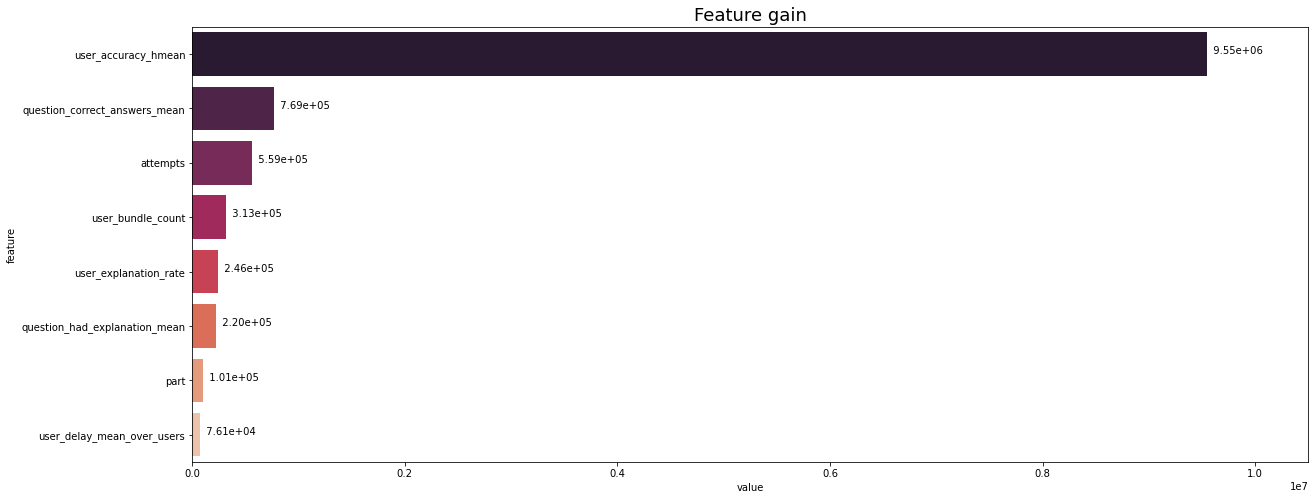

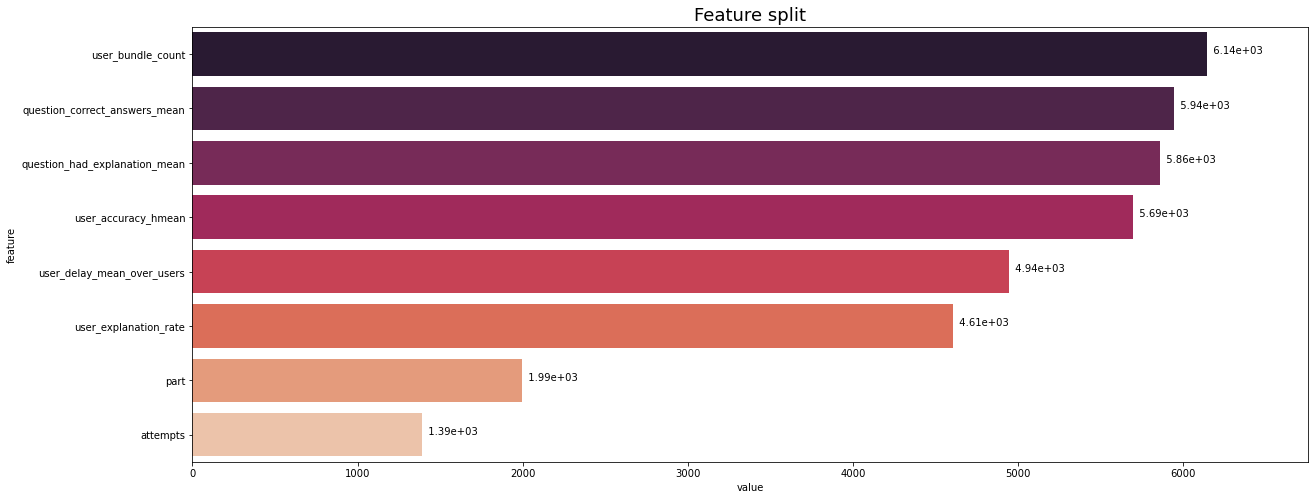

In [61]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = model.feature_name()
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model_profi, 'gain')
show_feature_importances(model_profi, 'split')

In [32]:
model_profi.save_model(os.path.join(user_data_path, 'model_lgbm_profi.lgb'))

## Модель для пользователей, которые мало отвечали

In [52]:
train_df_newbie = train_df.loc[train_df.user_bundle_count < 15, :]
train_df_newbie = pd.concat([train_df_newbie, train_newbie_df])
train_df.shape

(10000000, 16)

In [53]:
train_df_newbie = make_features_newbie(train_df)
valid_df_newbie = make_features_newbie(valid_dfs['first_user_answers'])

In [54]:
lgbm_train = lgbm.Dataset(data = train_df_newbie.drop(columns='answered_correctly'),#.iloc[:1000000, :],
                          label = train_df_newbie.loc[:, 'answered_correctly'],#.iloc[:1000000],
                          categorical_feature=['part'],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df_newbie.drop(columns='answered_correctly'),
                          label = valid_df_newbie.loc[:, 'answered_correctly'],
                          categorical_feature=['part'],
                          free_raw_data = False)

In [55]:
params = {#'boosting_type': 'gbdt',
#           'max_depth' : -1,
          'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 100,
#           'learning_rate': 0.1,
#           'subsample': 0.8,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 0.01,
#           'reg_lambda': 100,
          'metric' : 'auc',
          'random_state': 17,
          'num_boost_round': 10000,
          'verbose_eval': 50,
          'early_stopping_rounds': 100
         }
model_newbie = lgbm.train(
    params = params,
    train_set = lgbm_train,
    valid_sets = [lgbm_valid]
)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.707099
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.704969
[3]	valid_0's auc: 0.693382
[4]	valid_0's auc: 0.70604
[5]	valid_0's auc: 0.704336
[6]	valid_0's auc: 0.70604
[7]	valid_0's auc: 0.708753
[8]	valid_0's auc: 0.706421
[9]	valid_0's auc: 0.707693
[10]	valid_0's auc: 0.706485
[11]	valid_0's auc: 0.706179
[12]	valid_0's auc: 0.706869
[13]	valid_0's auc: 0.706419
[14]	valid_0's auc: 0.706962
[15]	valid_0's auc: 0.707251
[16]	valid_0's auc: 0.707397
[17]	valid_0's auc: 0.7073
[18]	valid_0's auc: 0.707392
[19]	valid_0's auc: 0.707449
[20]	valid_0's auc: 0.708331
[21]	valid_0's auc: 0.708208
[22]	valid_0's auc: 0.707637
[23]	valid_0's auc: 0.708434
[24]	valid_0's auc: 0.707647
[25]	valid_0's auc: 0.70681
[26]	valid_0's auc: 0.705335
[27]	valid_0's auc: 0.705504
[28]	valid_0's auc: 0.70515
[29]	valid_0's auc: 0.705896
[30]	valid_0's auc: 0.706205
[31]	valid_0's auc: 0.706541
[32]	valid_0's auc: 0.706994
[33]	valid_0's auc: 0.707

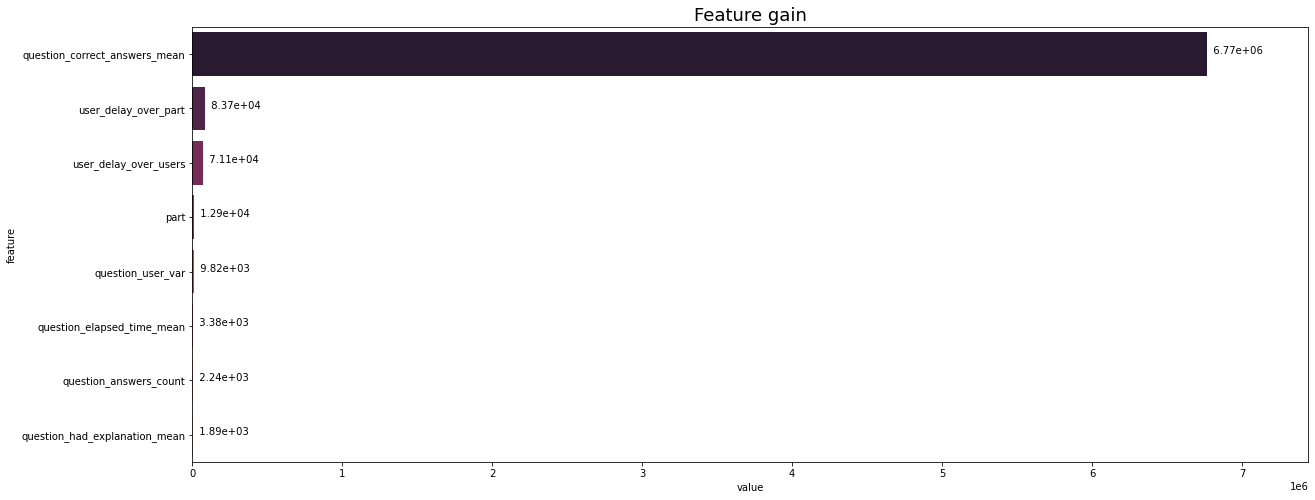

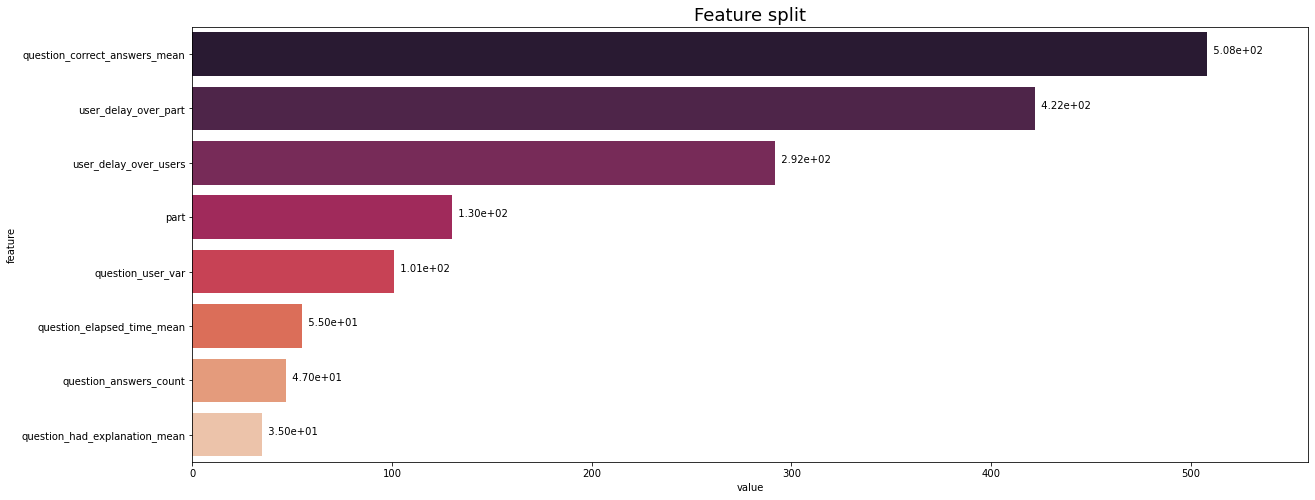

In [69]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = model.feature_name()
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model_newbie, 'gain')
show_feature_importances(model_newbie, 'split')

In [32]:
model.save_model(os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

## Проверка предсказаний

In [64]:
from sklearn.metrics import roc_auc_score

In [76]:
test_df = pd.concat([valid_dfs['first_user_answers'], valid_dfs['last_user_answers']])
ypred = make_prediction(test_df, model_profi, model_newbie, 1)
roc_auc_score(test_df['answered_correctly'], ypred)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0.740096820470971

# Поиск по сетке параметров

In [24]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'rb') as fo:
    train_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'valid_df.pickle'), 'rb') as fo:
    valid_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'rb') as fo:
    users_chars = pickle.load(fo)
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    q_chars = pickle.load(fo)
    
memory_usage(train_df, 'train_df')
memory_usage(valid_df, 'valid_df')
memory_usage(q_chars, 'question_characteristics')
memory_usage(users_chars, 'users_chars')

train_df use 915.53 mb in memory
valid_df use 14.88 mb in memory
question_characteristics use 0.67 mb in memory
users_chars use 18.02 mb in memory


In [25]:
lgbm_train = lgbm.Dataset(data = train_df.drop(columns='answered_correctly').iloc[:1000000, :],
                          label = train_df.loc[:, 'answered_correctly'].iloc[:1000000],
                          categorical_feature=[0],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df.drop(columns='answered_correctly'),
                          label = valid_df.loc[:, 'answered_correctly'],
                          categorical_feature=[0],
                          free_raw_data = False)

In [26]:
def combine_parameters(static_parameters, dynamic_parameters):
    """
    Фнкция составления списка наборов параметров из заданного словаря
    """
    if not dynamic_parameters:
        return static_parameters

    keys = list(dynamic_parameters.keys())
    settings = []

    if len(keys) == 1:
        key = keys[0]
        current_settings = static_parameters
        for param in dynamic_parameters[key]:
            current_settings[key] = param
            settings.append(current_settings.copy())
    else:
        key = keys[0]
        current_settings = static_parameters
        current_dyn_params = dict([(name, val) for name, val in dynamic_parameters.items() if name != key])
        for param in dynamic_parameters[key]:
            current_settings[key] = param

            current_parameters = combine_parameters(current_settings.copy(), current_dyn_params)
            settings += current_parameters

    return settings

In [36]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 38,
          'learning_rate': 0.1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'reg_alpha': 0.01,
          'reg_lambda': 100,
          'metric' : 'auc',
          'random_state': 17,
          'num_boost_round': 2500,
          'verbose_eval': 10,
          'early_stopping_rounds': 10
         }

gridParams = {
#     'learning_rate': [0.01, 0.1, 1.],
    'num_leaves': [10, 30, 100, 500, 1000],
#     'reg_alpha' : [0.001, 0.01, 0.1],
#     'reg_lambda' : [10, 100, 1000],
    }
# NUM_BOOST_ROUND = 2500
# VERBOSE_EVAL = 25

# mdl = lgbm.LGBMClassifier(boosting_type= 'gbdt',
#                         objective = 'binary',
#                         n_jobs = 3, # Updated from 'nthread'
#                         silent = True,
#                         max_depth = params['max_depth'],
#                         max_bin = params['max_bin'],
#                         subsample_for_bin = params['subsample_for_bin'],
#                         subsample = params['subsample'],
#                         subsample_freq = params['subsample_freq'],
#                         min_split_gain = params['min_split_gain'],
#                         min_child_weight = params['min_child_weight'],
#                         min_child_samples = params['min_child_samples'],
#                         scale_pos_weight = params['scale_pos_weight'])
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=4,
#                     n_jobs=2)

In [37]:
score_list = []
param_list = combine_parameters(params, gridParams)

for current_params in param_list:
    model = lgbm.train(params=current_params, train_set = lgbm_train, valid_sets = [lgbm_valid])
    y_predict = model.predict(lgbm_valid.data)
    score_list.append(metrics.roc_auc_score(lgbm_valid.label, y_predict))

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.692812
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.724569
[3]	valid_0's auc: 0.715703
[4]	valid_0's auc: 0.71997
[5]	valid_0's auc: 0.73692
[6]	valid_0's auc: 0.738892
[7]	valid_0's auc: 0.740201
[8]	valid_0's auc: 0.741841
[9]	valid_0's auc: 0.741844
[10]	valid_0's auc: 0.744275
[11]	valid_0's auc: 0.743767
[12]	valid_0's auc: 0.744377
[13]	valid_0's auc: 0.744862
[14]	valid_0's auc: 0.744896
[15]	valid_0's auc: 0.745394
[16]	valid_0's auc: 0.745535
[17]	valid_0's auc: 0.745387
[18]	valid_0's auc: 0.745695
[19]	valid_0's auc: 0.74552
[20]	valid_0's auc: 0.745955
[21]	valid_0's auc: 0.745994
[22]	valid_0's auc: 0.746091
[23]	valid_0's auc: 0.746968
[24]	valid_0's auc: 0.747145
[25]	valid_0's auc: 0.747393
[26]	valid_0's auc: 0.747596
[27]	valid_0's auc: 0.748156
[28]	valid_0's auc: 0.749968
[29]	valid_0's auc: 0.750235
[30]	valid_0's auc: 0.750177
[31]	valid_0's auc: 0.750176
[32]	valid_0's auc: 0.74994
[33]	valid_0's auc: 0.74

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.681786
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.718565
[3]	valid_0's auc: 0.727981
[4]	valid_0's auc: 0.730421
[5]	valid_0's auc: 0.741097
[6]	valid_0's auc: 0.744635
[7]	valid_0's auc: 0.743515
[8]	valid_0's auc: 0.745779
[9]	valid_0's auc: 0.747209
[10]	valid_0's auc: 0.748561
[11]	valid_0's auc: 0.747264
[12]	valid_0's auc: 0.745723
[13]	valid_0's auc: 0.7461
[14]	valid_0's auc: 0.747136
[15]	valid_0's auc: 0.747412
[16]	valid_0's auc: 0.747089
[17]	valid_0's auc: 0.747642
[18]	valid_0's auc: 0.747623
[19]	valid_0's auc: 0.747512
[20]	valid_0's auc: 0.749032
[21]	valid_0's auc: 0.74825
[22]	valid_0's auc: 0.748464
[23]	valid_0's auc: 0.749184
[24]	valid_0's auc: 0.749659
[25]	valid_0's auc: 0.748939
[26]	valid_0's auc: 0.749417
[27]	valid_0's auc: 0.750028
[28]	valid_0's auc: 0.750607
[29]	valid_0's auc: 0.751078
[30]	valid_0's auc: 0.750575
[31]	valid_0's auc: 0.750647
[32]	valid_0's auc: 0.751515
[33]	valid_0's auc: 0.7

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.720445
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.727728
[3]	valid_0's auc: 0.733256
[4]	valid_0's auc: 0.734823
[5]	valid_0's auc: 0.739981
[6]	valid_0's auc: 0.737501
[7]	valid_0's auc: 0.738442
[8]	valid_0's auc: 0.742359
[9]	valid_0's auc: 0.74248
[10]	valid_0's auc: 0.745596
[11]	valid_0's auc: 0.743498
[12]	valid_0's auc: 0.742945
[13]	valid_0's auc: 0.742573
[14]	valid_0's auc: 0.744035
[15]	valid_0's auc: 0.74424
[16]	valid_0's auc: 0.744447
[17]	valid_0's auc: 0.744419
[18]	valid_0's auc: 0.744351
[19]	valid_0's auc: 0.744836
[20]	valid_0's auc: 0.745628
[21]	valid_0's auc: 0.745031
[22]	valid_0's auc: 0.74491
[23]	valid_0's auc: 0.744988
[24]	valid_0's auc: 0.745804
[25]	valid_0's auc: 0.746238
[26]	valid_0's auc: 0.74686
[27]	valid_0's auc: 0.74746
[28]	valid_0's auc: 0.74894
[29]	valid_0's auc: 0.749028
[30]	valid_0's auc: 0.748842
[31]	valid_0's auc: 0.747517
[32]	valid_0's auc: 0.747356
[33]	valid_0's auc: 0.7475

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.720434
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.727214
[3]	valid_0's auc: 0.732699
[4]	valid_0's auc: 0.735086
[5]	valid_0's auc: 0.742749
[6]	valid_0's auc: 0.744609
[7]	valid_0's auc: 0.74561
[8]	valid_0's auc: 0.748619
[9]	valid_0's auc: 0.747815
[10]	valid_0's auc: 0.75022
[11]	valid_0's auc: 0.748768
[12]	valid_0's auc: 0.748999
[13]	valid_0's auc: 0.749721
[14]	valid_0's auc: 0.750914
[15]	valid_0's auc: 0.750595
[16]	valid_0's auc: 0.750312
[17]	valid_0's auc: 0.750298
[18]	valid_0's auc: 0.750141
[19]	valid_0's auc: 0.749613
[20]	valid_0's auc: 0.750569
[21]	valid_0's auc: 0.7503
[22]	valid_0's auc: 0.75088
[23]	valid_0's auc: 0.751288
[24]	valid_0's auc: 0.752302
[25]	valid_0's auc: 0.752791
[26]	valid_0's auc: 0.752898
[27]	valid_0's auc: 0.7537
[28]	valid_0's auc: 0.753799
[29]	valid_0's auc: 0.754115
[30]	valid_0's auc: 0.753966
[31]	valid_0's auc: 0.75394
[32]	valid_0's auc: 0.753603
[33]	valid_0's auc: 0.753266

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.71943
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.727208
[3]	valid_0's auc: 0.731399
[4]	valid_0's auc: 0.736553
[5]	valid_0's auc: 0.744432
[6]	valid_0's auc: 0.7458
[7]	valid_0's auc: 0.746757
[8]	valid_0's auc: 0.749513
[9]	valid_0's auc: 0.7489
[10]	valid_0's auc: 0.750554
[11]	valid_0's auc: 0.748994
[12]	valid_0's auc: 0.747649
[13]	valid_0's auc: 0.747494
[14]	valid_0's auc: 0.749317
[15]	valid_0's auc: 0.74836
[16]	valid_0's auc: 0.747911
[17]	valid_0's auc: 0.747923
[18]	valid_0's auc: 0.748282
[19]	valid_0's auc: 0.748164
[20]	valid_0's auc: 0.749653
Early stopping, best iteration is:
[10]	valid_0's auc: 0.750554


In [38]:
i = np.argmax(score_list)
best_params = dict((key, val) for key, val in param_list[i].items() if key in gridParams.keys())
print('best score {:.5f} on {}'.format(score_list[i], best_params))

best score 0.75944 on {'num_leaves': 100}


In [30]:
%%time
grid.fit(train_df.iloc[:1000000, :], train_df.iloc[:1000000, :]['answered_correctly'])

CPU times: user 5.19 s, sys: 1.33 s, total: 6.52 s
Wall time: 4min 34s


GridSearchCV(cv=4,
             estimator=LGBMClassifier(max_bin=512, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_jobs=3, objective='binary',
                                      scale_pos_weight=1, subsample=1,
                                      subsample_for_bin=200, subsample_freq=1),
             n_jobs=2,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.3, 0.6],
                         'learning_rate': [0.05, 0.5], 'n_estimators': [40],
                         'num_leaves': [3, 6, 8], 'objective': ['binary'],
                         'random_state': [501], 'reg_alpha': [0.1, 1],
                         'reg_lambda': [0.1, 1], 'subsample': [0.4, 0.7]})

In [31]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.3,
 'learning_rate': 0.5,
 'n_estimators': 40,
 'num_leaves': 3,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.4}

In [32]:
model.best_score['valid_0']['auc']

0.7710950884905755

In [108]:
model.save_model(os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

In [110]:
model_2 = lgbm.Booster(model_file=os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

In [112]:
model_2.predict(valid_df)

array([0.67026076, 0.1258083 , 0.1258083 , ..., 0.97617155, 0.57685161,
       0.55882361])

In [113]:
metrics.roc_auc_score(valid_df['answered_correctly'], model_2.predict(valid_df))

0.7807047143355663

In [13]:
# param = {
#         'num_leaves': 80,
#         'max_bin': 250,
#         'min_data_in_leaf': 11,
#         'learning_rate': 0.01,
#         'min_sum_hessian_in_leaf': 0.00245,
#         'bagging_fraction': 1.0, 
#         'bagging_freq': 5, 
#         'feature_fraction': 0.05,
#         'lambda_l1': 4.972,
#         'lambda_l2': 2.276,
#         'min_gain_to_split': 0.65,
#         'max_depth': 14,
#         'save_binary': True,
#         'seed': 1337,
#         'feature_fraction_seed': 1337,
#         'bagging_seed': 1337,
#         'drop_seed': 1337,
#         'data_random_seed': 1337,
#         'objective': 'binary',
#         'boosting_type': 'gbdt',
#         'verbose': 1,
#         'metric': 'auc',
#         'is_unbalance': True,
#         'boost_from_average': False,
#         'device': 'cpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
#     }

posx and posy should be finite values
posx and posy should be finite values


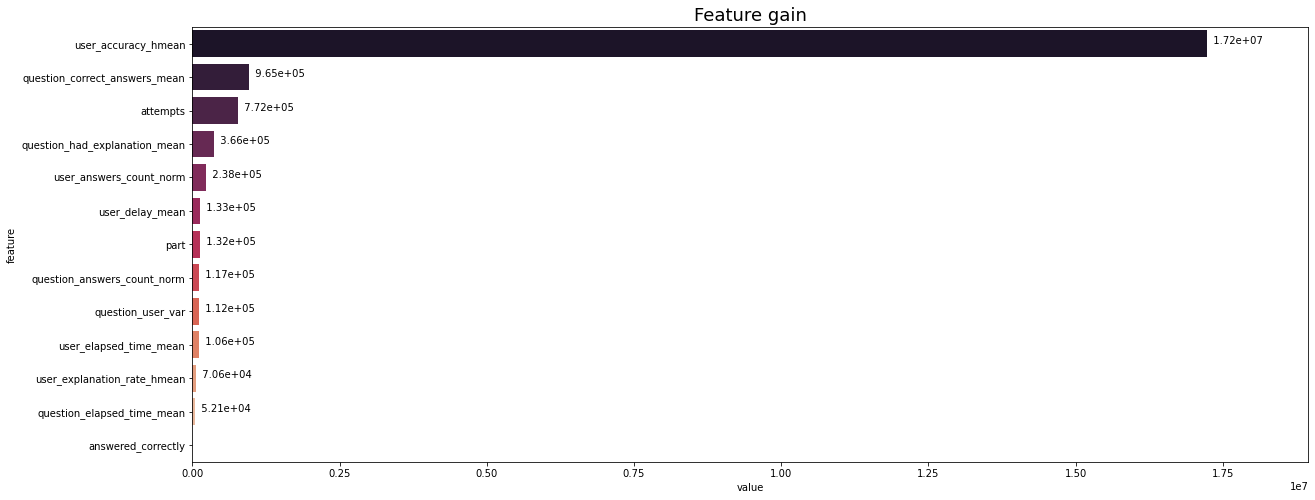

posx and posy should be finite values
posx and posy should be finite values


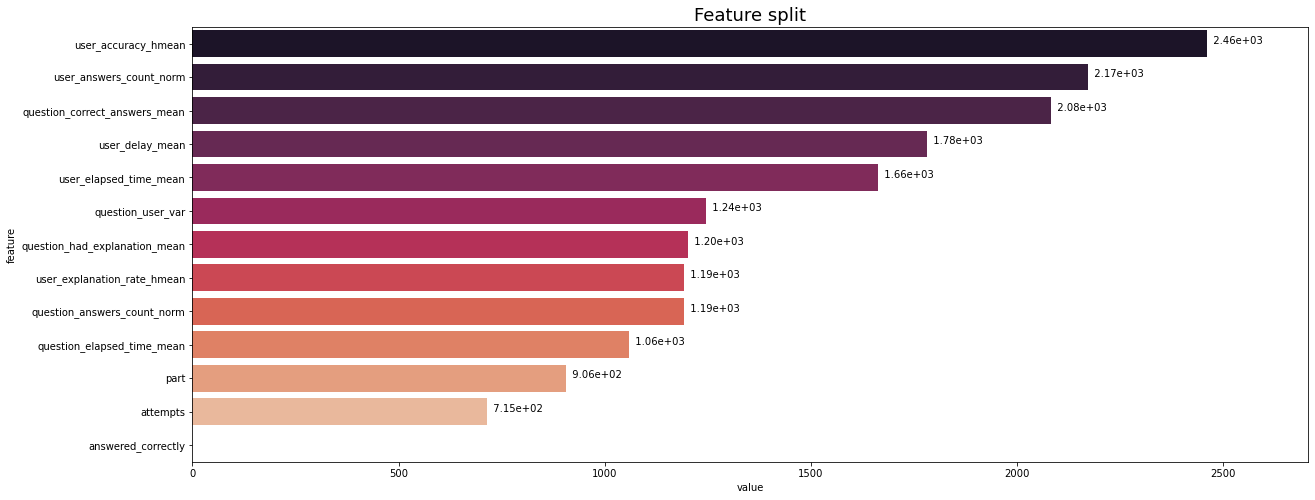

In [92]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = train_df.columns
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [85]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(valid_df)

SHAPError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

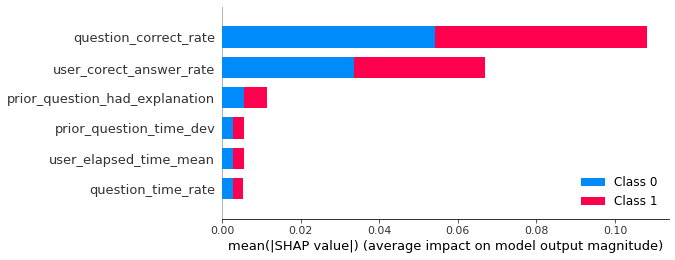

In [18]:
shap.summary_plot(shap_values, valid_features_df, plot_type="bar",
                  title = "")

# Predictions

In [23]:
import riiideducation
env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation'

In [ ]:
# Here you would also add your pretrained model
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    # --- PREPROCESSING ---
    # Here is time to apply the preprocessing to the test_df
    test_df = merge_data(test_df, questions_df, data_type='test')
    test_df, last_answers = get_answer_time_characteristics(test_df, last_answers)
    test_df = get_features_df(test_df, q_chars, questions_df)
    
    # --- MODEL ---
    test_df['answered_correctly'] = lgbm_2.predict(test_df, num_iteration = lgbm_2.best_iteration)
    env.predict(test_df.reset_index()[['row_id', 'answered_correctly']])

In [32]:
df = pd.DataFrame({
    'a': ['1', '1', '1'],
    'b': [2, np.nan, np.nan]
})
df.drop_duplicates()

,a,b
0,1,2.0
1,1,NaN
